In [19]:
# the data formatting might be a problem
import csv
import math
import os  
import time 

from keras._tf_keras.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras._tf_keras.keras.metrics import MeanAbsoluteError, Accuracy, Precision, Recall, MeanSquaredError
from keras._tf_keras.keras.models import Sequential
from keras._tf_keras.keras.optimizers import Adam , RMSprop, Nadam
from keras._tf_keras.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization, Masking, InputLayer, Conv1D, MaxPooling1D, Flatten, TimeDistributed, LayerNormalization, Activation
from keras._tf_keras.keras.regularizers import L1L2, L1, L2
from keras._tf_keras.keras.utils import to_categorical
from matplotlib import pyplot as plt
import numpy as np 
import pandas as pd
import seaborn as sns

from sklearn.calibration import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import StandardScaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder 

from FeatureEngineering import FeatureEngineering as fe 

In [4]:
def create_dataframe_from_data(input_path: str):
    dataframes = []
    for file_name in os.listdir(input_path):
        file_path = os.path.join(input_path, file_name)

        data = np.load(file_path, allow_pickle=True)
        df = pd.DataFrame(data)

        gesture = file_name.split("_")[0]
        gesture_index = int(file_name.split("_")[1].split(".")[0])
        
        # add two new columns to df 
        df["gesture"] = gesture
        df["gesture_index"] = gesture_index

        dataframes.append(df)
        df.sort_values(by="frame", inplace=True)
    
    return pd.concat(dataframes, ignore_index=True) if len(dataframes) > 0 else ValueError("Dataframe is empty")

def create_dict_from_df(df: pd.DataFrame):
    diction = {x: [] for x in np.unique(df["gesture"].values.tolist())}
    for gesture_index, gesture_data in df.groupby("gesture_index"):
        gesture = np.unique(gesture_data["gesture"].values.tolist())[0]
        tmp = diction[gesture] + [gesture_index]
        diction.update({gesture:tmp})
    return diction

def transform_to_sequences(df: pd.DataFrame, sequence_length, target: str, additional_targets: list = None):
    sequences = []
    labels = []
    grouped = df.groupby('gesture_index')
    
    for _, group in grouped:
        group = group.sort_values('frame').reset_index(drop=True)
        for i in range(0, len(group), sequence_length):
            sequence = group.iloc[i:i+sequence_length].drop(columns=['gesture_index']).values # gesture_index is dropped because it's more like metadata, no value as a features
            if len(sequence) == sequence_length:
                sequences.append(sequence)
                labels.append(group.iloc[0][[target] + additional_targets]) if additional_targets else labels.append(group.iloc[0][target])
    return np.array(sequences), np.array(labels) 

def split_dataset(df: pd.DataFrame, target_label: str, sequence_length=30, additional_targets: list=None, train_ratio=0.7, val_ratio=0.15 ,test_ratio=0.15):
    # probably make this train, val, test
    assert train_ratio + val_ratio + test_ratio == 1.0, "ratios must sum to 1."

    gesture_index_dict = create_dict_from_df(df)

    train_indices = []
    val_indices = []
    test_indices = []

    for _, indices in gesture_index_dict.items():
        n_total = len(indices)
        n_train = math.ceil(n_total * train_ratio)
        n_val = math.ceil(n_total * val_ratio)
        
        train_indices.extend(indices[:n_train])
        val_indices.extend(indices[n_train:n_train + n_val])
        test_indices.extend(indices[n_train + n_val:])

    grouped_data = df.groupby("gesture_index")

    train_frames, val_frames, test_frames = [], [], []
    for idx in train_indices:
        train_frames.append(grouped_data.get_group(idx))
        
    for idx in val_indices:
        val_frames.append(grouped_data.get_group(idx))
        
    for idx in test_indices:
        test_frames.append(grouped_data.get_group(idx))

    # Concatenate the dataframes to create the final train and test sets
    train_set = pd.concat(train_frames).reset_index(drop=True)
    val_set = pd.concat(val_frames).reset_index(drop=True)
    test_set = pd.concat(test_frames).reset_index(drop=True)
    
    # X_train_sequences, y_train_sequences = transform_to_sequences(train_set,  sequence_length, target_label, additional_targets)
    # X_val_sequences, y_val_sequences = transform_to_sequences(val_set,  sequence_length, target_label, additional_targets)
    # X_test_sequences, y_test_sequences = transform_to_sequences(test_set,  sequence_length, target_label, additional_targets)

    # Separate X and y
    # X_train = X_train_sequences
    # y_train = y_train_sequences
    # X_val = X_val_sequences
    # y_val = y_val_sequences
    # X_test = X_test_sequences
    # y_test = y_test_sequences

    X_train = train_set.drop(columns=[target_label])
    y_train = train_set[[target_label] + additional_targets] if additional_targets else train_set[[target_label]]
    X_val = val_set.drop(columns=[target_label])
    y_val = val_set[[target_label] + additional_targets] if additional_targets else train_set[[target_label]]
    X_test = test_set.drop(columns=[target_label])
    y_test = test_set[[target_label] + additional_targets] if additional_targets else test_set[[target_label]]


    return X_train, y_train, X_val, y_val, X_test, y_test

def save_sequences_to_csv(sequences, labels, filename, df):
    with open(filename, mode="w", newline='') as file:
        writer = csv.writer(file)
        header = []      
        for i in range(30):
            for col in df.columns[:-2]:  # Exclude 'gesture_index' and 'gesture' columns
                header.append(f"{col}_frame_{i}")
        header.append("gesture")
        writer.writerow(header)
        
        # Write data
        for sequence, label in zip(sequences, labels):
            flattened_sequence = sequence.flatten()
            writer.writerow(np.append(flattened_sequence, label))

def calculate_hand_motion_feature(df: pd.DataFrame, landmark_cols: list):
    df_copy = df.copy()
    s = time.process_time()
    df_temporal = fe.calculate_temporal_features(df_copy, landmark_cols)
    print(time.process_time()-s)
    # Ensure there are no duplicate columns
    df_combined = df_copy.loc[:,~df_copy.columns.duplicated()]
    return df_combined

def preprocess_pipeline(timeseries_columns, numerical_columns, categorical_columns):
    ts_numerical_transformer = Pipeline(steps=[
        ('imputer', KNNImputer(n_neighbors=5)), # might want to change this out back to the interpolatioon methods
        ('imputer2', SimpleImputer(strategy="mean")),
        ('scaler', StandardScaler())
    ])

    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy="mean")),
        ("normalize", StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy="most_frequent")), # technically this is wrong
        ("ohe", OneHotEncoder(sparse_output=False))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('ts_num', ts_numerical_transformer, timeseries_columns),
            ('num', numerical_transformer, numerical_columns),
            # ('cat', categorical_transformer, categorical_columns)
        ],
        remainder='passthrough',
        sparse_threshold=0,
        n_jobs=-1
    )
 
    preprocessor.set_output(transform="pandas")
    
    return preprocessor


In [5]:

input_path = r'C:\Users\Gen3r\Documents\capstone\ml_model\data\data_3'
dataframe = create_dataframe_from_data(input_path)

X_train, y_train, X_val, y_val, X_test, y_test = split_dataset(dataframe, target_label='gesture')
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

landmark_columns = [f"{col}" for col in dataframe.columns if col.startswith(("hx", "hy", "hz", "px", "py", "pz", "lx", "ly", "lz", "rx", "ry", "rz"))]
categorical_columns = ["gesture_index"]
numerical_columns = ["frame", "frame_rate", "frame_width", "frame_height"] + [f"{col}" for col in dataframe.columns if col.startswith("pose_visibility")]
derived_features =  [f"{feat}_{col}" for feat in ["velocity", "acceleration", "jerk"] for col in landmark_columns if col.startswith(("lx", "ly", "lz", "rx", "ry", "rz"))]
time_series_columns = landmark_columns + derived_features     
res = [item for item in landmark_columns if item.startswith(("r", "l"))]


X_train_fe = calculate_hand_motion_feature(X_train, res)
X_val_fe = calculate_hand_motion_feature(X_val, res)
X_test_fe = calculate_hand_motion_feature(X_test, res)

preprocessor = preprocess_pipeline(time_series_columns, numerical_columns, categorical_columns)

X_train_transformed = preprocessor.fit_transform(X_train_fe)
X_val_transformed = preprocessor.transform(X_val_fe)
X_test_transformed = preprocessor.transform(X_test_fe)

(7320, 1667) (7320, 1) (1650, 1667) (7320, 1) (1470, 1667) (1470, 1)
46.609375
10.609375
9.5


In [6]:
def transform_to_sequenceses(df: pd.DataFrame, sequence_length, target: str, additional_targets: list = None):
    sequences = []
    labels = []
    grouped = df.groupby('remainder__gesture_index')
    
    for _, group in grouped:
        group = group.sort_values('num__frame').reset_index(drop=True)
        for i in range(0, len(group) - sequence_length + 1, sequence_length):
            sequence = group.iloc[i:i+sequence_length].drop(columns=['remainder__gesture_index', target] + (additional_targets if additional_targets else [])).values
            if len(sequence) == sequence_length:
                sequences.append(sequence)
                labels.append(group.iloc[0][target]) if additional_targets is None else labels.append(group.iloc[0][[target] + additional_targets])
    return np.array(sequences), np.array(labels)

# Assuming the target column name is 'gesture' and no additional targets
def create_sequences_with_labels(X_transformed, y, sequence_length):
    # Combine features and labels into a single DataFrame
    combined_df = pd.concat([pd.DataFrame(X_transformed), y.reset_index(drop=True)], axis=1)
    
    # Convert the DataFrame to sequences
    X_sequences, y_sequences = transform_to_sequenceses(combined_df, sequence_length, target='gesture')
    
    return X_sequences, y_sequences

# Define sequence length
sequence_length = 30  # or whatever is appropriate

# Create sequences for training, validation, and testing
X_train_sequences, y_train_sequences = create_sequences_with_labels(X_train_transformed, y_train, sequence_length)
X_val_sequences, y_val_sequences = create_sequences_with_labels(X_val_transformed, y_val, sequence_length)
X_test_sequences, y_test_sequences = create_sequences_with_labels(X_test_transformed, y_test, sequence_length)

# Print shapes to verify
print(X_train_sequences.shape)
print(X_val_sequences.shape)
print(X_test_sequences.shape)

(244, 30, 2044)
(55, 30, 2044)
(49, 30, 2044)


In [12]:
class_labels = np.unique(y_test_sequences.tolist())
class_labels

# Convert labels to categorical
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_sequences)
y_val_encoded = label_encoder.transform(y_val_sequences)
y_test_encoded = label_encoder.transform(y_test_sequences)

y_train_categorical = to_categorical(y_train_encoded, num_classes=len(label_encoder.classes_))
y_val_categorical = to_categorical(y_val_encoded, num_classes=len(label_encoder.classes_))
y_test_categorical = to_categorical(y_test_encoded, num_classes=len(label_encoder.classes_))


print(y_train_categorical.shape)
print(y_val_categorical.shape)
print(y_test_categorical.shape)


(244, 5)
(55, 5)
(49, 5)


In [13]:
print("X_train_sequences type:", type(X_train_sequences))
print("X_train_sequences shape:", X_train_sequences.shape)
print("y_train_categorical type:", type(y_train_categorical))
print("y_train_categorical shape:", y_train_categorical.shape)
print("X_val_sequences type:", type(X_val_sequences))
print("X_val_sequences shape:", X_val_sequences.shape)
print("y_val_categorical type:", type(y_val_categorical))
print("y_val_categorical shape:", y_val_categorical.shape)
print("X_test_sequences type:", type(X_test_sequences))
print("X_test_sequences shape:", X_test_sequences.shape)
print("y_test_categorical type:", type(y_test_categorical))
print("y_test_categorical shape:", y_test_categorical.shape)

# X_train_sequences = X_train_sequences.astype(np.float32)
# y_train_categorical = y_train_categorical.astype(np.float32)
# X_val_sequences = X_val_sequences.astype(np.float32)
# y_val_categorical = y_val_categorical.astype(np.float32)
# X_test_sequences = X_test_sequences.astype(np.float32)
# y_test_categorical = y_test_categorical.astype(np.float32)

X_train_sequences type: <class 'numpy.ndarray'>
X_train_sequences shape: (244, 30, 2044)
y_train_categorical type: <class 'numpy.ndarray'>
y_train_categorical shape: (244, 5)
X_val_sequences type: <class 'numpy.ndarray'>
X_val_sequences shape: (55, 30, 2044)
y_val_categorical type: <class 'numpy.ndarray'>
y_val_categorical shape: (55, 5)
X_test_sequences type: <class 'numpy.ndarray'>
X_test_sequences shape: (49, 30, 2044)
y_test_categorical type: <class 'numpy.ndarray'>
y_test_categorical shape: (49, 5)


In [49]:
# Define the CNN model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(sequence_length, 2044),  kernel_regularizer=L2(0.0001)),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=256, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(class_labels), activation='softmax', kernel_regularizer=L2(0.00001), bias_regularizer=L2(0.0001))  # Output layer for classification
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
# model.summary()

c:\Users\Gen3r\Documents\capstone\ml_model\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [54]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)	
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-10)	

# Train the model
history = model.fit(
    X_train_sequences, y_train_categorical,
    validation_data=(X_val_sequences, y_val_categorical),
    epochs=100,  # Adjust epochs as needed
    batch_size=30,  # Adjust batch size as needed
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_sequences, y_test_categorical)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9395 - loss: 0.2121 - val_accuracy: 0.2000 - val_loss: 7.4652 - learning_rate: 6.2500e-05
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9756 - loss: 0.0753 - val_accuracy: 0.2000 - val_loss: 7.2363 - learning_rate: 6.2500e-05
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9886 - loss: 0.0554 - val_accuracy: 0.2182 - val_loss: 7.4280 - learning_rate: 6.2500e-05
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9934 - loss: 0.0205 - val_accuracy: 0.2182 - val_loss: 7.5270 - learning_rate: 6.2500e-05
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9901 - loss: 0.0380 - val_accuracy: 0.2182 - val_loss: 7.5666 - learning_rate: 3.1250e-05
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9988 - loss: 0.0147 - val_accuracy: 0.2182 - val_loss: 7.5813 - learning_rate: 3.1250e-05
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9935 - loss:

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


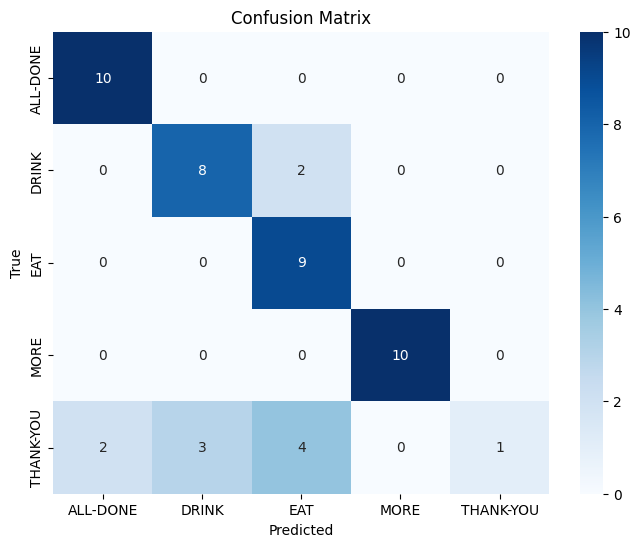

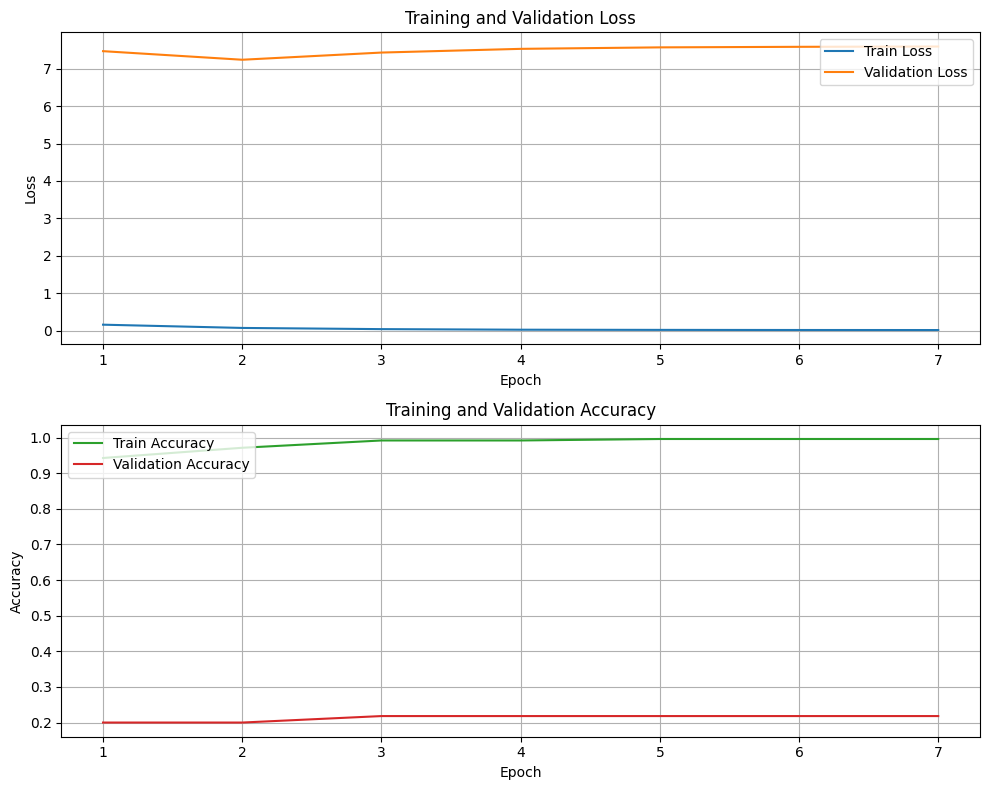

In [55]:
y_pred = model.predict(X_test_sequences)
y_test_labels = np.argmax(y_test_categorical, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)
labels = np.unique(np.concatenate((y_test_labels, y_pred_labels)))
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.ion()
plt.show()


# Extracting the history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Create a figure with two subplots (2 rows, 1 column)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot training and validation loss
ax1.plot(epochs, train_loss, label='Train Loss', color='tab:blue')
ax1.plot(epochs, val_loss, label='Validation Loss', color='tab:orange')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend(loc='upper right')
ax1.grid(True)

# Plot training and validation accuracy
ax2.plot(epochs, train_acc, label='Train Accuracy', color='tab:green')
ax2.plot(epochs, val_acc, label='Validation Accuracy', color='tab:red')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend(loc='upper left')
ax2.grid(True)

# Adjust layout to prevent overlap
fig.tight_layout()

# Display the plots
plt.show()

In [22]:
model.save(f"model_good{time.time_ns()}.keras")